In [1]:
import os
import sys
sys.path.append("../")

import math
import random
from scipy import special
import numpy as np
import torch
# import tensorflow as tf
import matplotlib.pyplot as plt
import time
import logging
from pynverse import inversefunc
from utilities.compare_performance import compare_performance
import scipy.io
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
from functools import partial

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
import numpy as np
from sympy import *
import sympy as sp
#import scipy.integrate as integrate
import scipy.special as special
from scipy.integrate import quad

mu = 0.05
dim = 1 
m=2
    
def exact_example(t, x, T):
    xi = (1+sum(x))/2
    return 2*np.pi*mu*np.exp(-np.pi**2*mu*dim*(T-t))*np.sin(np.pi*xi)/(m+np.exp(-np.pi**2*mu*dim*(T-t))*np.cos(np.pi*xi))


In [3]:
nu=mu*4

def f_example(y, coordinate=0):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    """
    return -2*y[0]*y[1:(dim+1)].sum(dim=0) 
  
def dgm_f_example(y, coordinate=0):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> second deriv
    """
    return -2*y[0]*y[1:(dim+1)].sum(dim=0) + nu*y[(dim+1):(2*dim+1)].sum(dim=0)

def phi_example(x, coordinate=0):
    return 2*mu*torch.pi*torch.sin(torch.pi*(1+x.sum(axis=0))/2)/(m+torch.cos(torch.pi*(1+x.sum(axis=0))/2))

# def exact_example(t, x, T):
#    xi = T-t + x.sum(axis=0)
#    return np.sin(np.pi*(1+xi)/2)

def boundary_fun(x, coordinate=0):
    return torch.tensor(np.zeros(x.size()[1]), device=device).to(torch.float32)

t_lo, x_lo, x_hi = 0., -1, 1
    
x_mid = (x_lo + x_hi) / 2
grid = np.linspace(x_lo, x_hi, 100)

Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


#### Starting deep branching method with seed 0 - 1 out of 1 times
Generating batch 1/40
Generating batch 2/40
Generating batch 3/40
Generating batch 4/40
Generating batch 5/40
Generating batch 6/40
Generating batch 7/40
Generating batch 8/40
Generating batch 9/40
Generating batch 10/40
Generating batch 11/40
Generating batch 12/40
Generating batch 13/40
Generating batch 14/40
Generating batch 15/40
Generating batch 16/40
Generating batch 17/40
Generating batch 18/40
Generating batch 19/40
Generating batch 20/40
Generating batch 21/40
Generating batch 22/40
Generating batch 23/40
Generating batch 24/40
Generating batch 25/40
Generating batch 26/40
Generating batch 27/40
Generating batch 28/40
Generating batch 29/40
Generating batch 30/40
Generating batch 31/40
Generating batch 32/40
Generating batch 33/40
Generating batch 34/40
Generating batch 35/40
Generating batch 36/40
Generating batch 37/40
Generating batch 38/40
Generating batch 39/40
Generating batch 40/40


Patch 0: generation of u samples take 1799.3274960517883 seconds.
Patch  0: epoch    0 with loss 1.46E+00
Patch  0: epoch  500 with loss 4.65E-04
Patch  0: epoch 1000 with loss 1.62E-04
Patch  0: epoch 1500 with loss 1.49E-04
Patch  0: epoch 2000 with loss 1.34E-04
Patch  0: epoch 2500 with loss 1.32E-04
Patch  0: epoch 3000 with loss 1.30E-04
Patch  0: epoch 3500 with loss 1.27E-04
Patch  0: epoch 4000 with loss 1.23E-04
Patch  0: epoch 4500 with loss 1.19E-04
Patch  0: epoch 4999 with loss 1.14E-04
Patch 0: training of u with 5000 epochs take 19.5149827003479 seconds.


Time taken: 1816 seconds; L1 error: 1.19E-02; L2 error: 2.38E-04; rel error: INF.
fdb runtime: 3 seconds; total runtime: 1819 seconds.




######## Summary for deep branching method
runtime:        1816
fdb runtime:    3
total runtime:  1819
mean L1 error:  1.19E-02
std L1 error:   0.00E+00
mean L2 error:  2.38E-04
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:84: RuntimeWarning: divide by zero encountered in divide
  branch_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
C:\Users\fiat\anaconda3\envs\pdenn\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


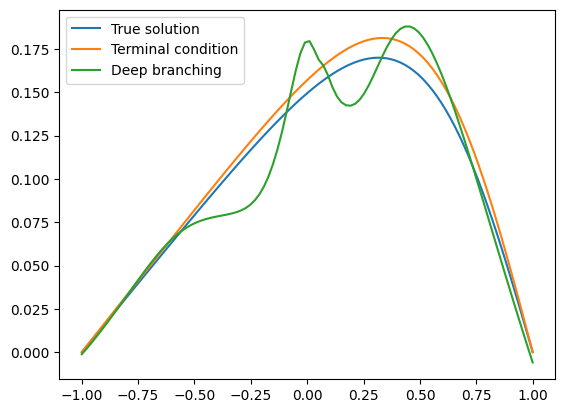

In [10]:
dim = 3
T=0.1/dim
grid_d_dim = np.concatenate((x_mid * np.ones((0, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)    
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)
deriv_map = np.concatenate((np.array([[0] * dim]), 1 * np.identity(dim), 2 * np.identity(dim)), axis=0).astype(int)

# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    # disable_branch=True,
                    continuous_branch=True,
                    disable_bsde=True, 
                    disable_galerkin=True, 
                    verbose=True, debug_mode=False,                     
                    y_lo=x_lo, y_hi=x_hi, nu=nu,
                    T=T, device=device, epochs=5000, fname="test_case_3",
                    branch_nb_states=10000, branch_nb_path_per_state=10000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=250,
                    second_order=True, bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    boundary_fun=boundary_fun, dgm_overtrain_rate=0, outlier_percentile=5,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=8,
                    save_for_best_model=False, save_as_tmp=True)

